In [114]:
import numpy as np
import random
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [105]:
# H9.2: C-SVM with standard parameters

p = 40
np.random.seed(42)

mu1 = np.array([0, 1])
mu2 = np.array([1, 0])
mu3 = np.array([0, 0])
mu4 = np.array([1, 1])
var = 0.1
cov = var*np.eye(2)

# function generating samples
def xor_data(p, mu_a, mu_b, cov):
  class_neg = []
  class_pos = []

  for _ in range(p):
    if np.random.rand() < 0.5:
      x = np.random.multivariate_normal(mu_a[0], cov)
    else:
      x = np.random.multivariate_normal(mu_a[1], cov)
    class_neg.append(x)

  for _ in range(p):
    if np.random.rand() < 0.5:
      x = np.random.multivariate_normal(mu_b[0], cov)
    else:
      x = np.random.multivariate_normal(mu_b[1], cov)
    class_pos.append(x)

  return np.vstack([class_neg, class_pos]), np.concatenate([-np.ones(p), np.ones(p)])

mu_neg = [mu1, mu2]
mu_pos = [mu3, mu4]

X_train, y_train = xor_data(p, mu_neg, mu_pos, cov) # shape: (80, 2), (80,)
X_test, y_test = xor_data(p, mu_neg, mu_pos, cov)

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

In [106]:
# train a C-SVM

clf = SVC(C=1.0, kernel='rbf', gamma='scale') # rbf kernel and standard parameters
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
wrong_pred = (y_pred != y_test).mean()

print(f"Percentage of wrong predictions: {wrong_pred*100:.2f}%")

Percentage of wrong predictions: 18.75%


Number of support vectors: 38


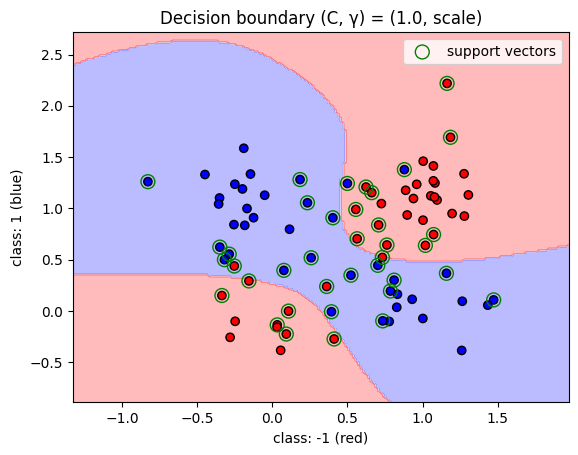

In [107]:
# visualize the results
# gamma symbol using unicode
gamma_symbol = "\u03B3"

def decision_boundary(clf, X, y, C, gamma, support, sv):
  x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
  x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

  x0, x1 = np.meshgrid(np.linspace(x0_min, x0_max, 200),
                        np.linspace(x1_min, x1_max, 200)) # xx.shape: (200, 200)

  grid_points = np.c_[x0.ravel(), x1.ravel()] # shape: (40000, 2)
  Z = clf.predict(grid_points).reshape(x0.shape)

  plt.contourf(x0, x1, Z, alpha=0.3, cmap='bwr')  # Decision boundary
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k')  # Training data

  # clf.support returns a list of indices of sv
  if len(support) != 0:
    print("Number of support vectors:", len(support))
  else:
    print("Support vectors are for the training-set.")

  # highlight support vectors
  if len(support) != 0:
    plt.scatter(sv[:, 0], sv[:, 1], s=100, facecolor='none', edgecolor='g', label='support vectors')
    plt.legend()
  plt.title(f"Decision boundary (C, {gamma_symbol}) = ({C}, {gamma})")
  plt.xlabel("class: -1 (red)")
  plt.ylabel("class: 1 (blue)")
  plt.show()

decision_boundary(clf, X_train, y_train, clf.C, clf.gamma, clf.support_, clf.support_vectors_)

In [117]:
# H9.3: C-SVM parameter optimization
# (a)
# define parameter grid (finer than given example)
C_range = [2**(t) for t in range(-6, 11)]
gamma_range = [2**(t) for t in range(-5, 10)]
param_grid = {'C': C_range, 'kernel': ['rbf'], 'gamma': gamma_range}

# initialize gridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=10, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1,
                               2, 4, 8, 16, 32, 64, 128, 256, 512, 1024],
                         'gamma': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4,
                                   8, 16, 32, 64, 128, 256, 512],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

Best combination (C, γ) = (2, 4)
Percentage of wrong predictions: 18.75%
Support vectors are for the training-set.


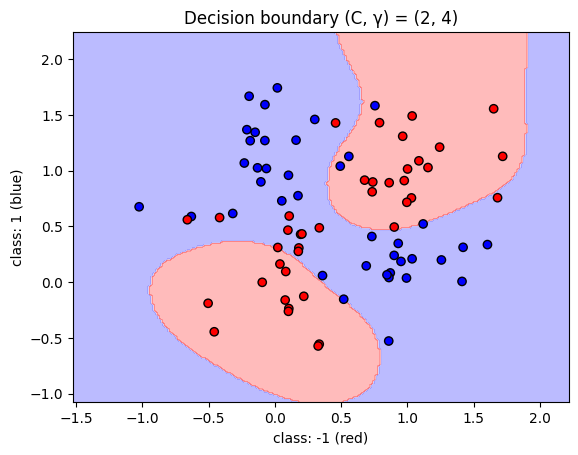

In [118]:
# (b) finding combination of C and gamma yielding the best cv performance
best_C = grid_search.best_params_['C']
best_gamma = grid_search.best_params_['gamma']
print(f"Best combination (C, {gamma_symbol}) =", (best_C, best_gamma))

# train a C-SVM with best parameters
clf_new = SVC(C=best_C, kernel='rbf', gamma=best_gamma) # rbf kernel and standard parameters
clf_new.fit(X_train, y_train)

y_pred_best = clf_new.predict(X_test)
wrong_pred_best = (y_pred_best != y_test).mean()
print(f"Percentage of wrong predictions: {wrong_pred_best*100:.2f}%")

# plot the result
decision_boundary(clf_new, X_test, y_test, clf_new.C, clf_new.gamma, [], 0)

Percentage of wrong predictions: 17.50%
Number of support vectors: 50


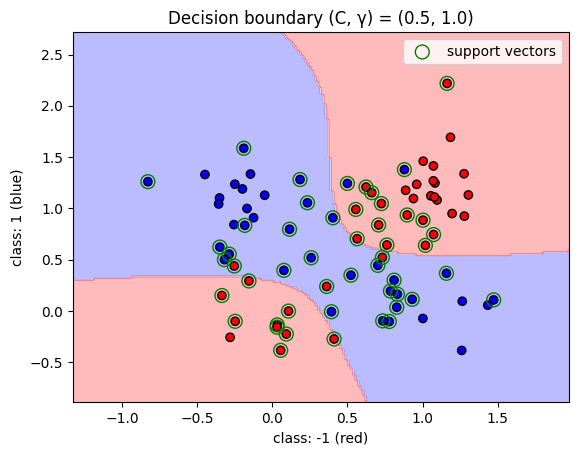

In [119]:
# (c)
best_C_4 = best_C / 4
best_gamma_4 = best_gamma / 4

clf_final = SVC(C=best_C_4, kernel='rbf', gamma=best_gamma_4) # rbf kernel and standard parameters
clf_final.fit(X_train, y_train)

y_pred_final = clf_final.predict(X_test)
wrong_pred_final = (y_pred_final != y_test).mean()
print(f"Percentage of wrong predictions: {wrong_pred_final*100:.2f}%")

# plot the result
decision_boundary(clf_final, X_train, y_train, clf_final.C, clf_final.gamma, clf_final.support_, clf_final.support_vectors_)

# interpretation
# case 1: setting hyperparameter grid (C, gamma) given in exercise sheet
# Compared to H9.2 we get less support vectors.
# This implies a simpler decision boundary, which is a positive sign, since a simpler model often generalizes better.
# However, we cannot conclude that we have a better model, since the test error is not improved.

# case 2: setting hyperparameter grid (C, gamma) finer
# Compared to H9.2 we get slightly lower test errors (18.75% vs. 17.50%).
# However we get higher complexity since we get more support vectors (38 vs. 50).
# We can conclude that the case 2 shows a better generalization even though higher complexity in terms of trade-off.